In [12]:
%matplotlib inline
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms



## Load Data:

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [3]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Define the Autoencoder:

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)
net = net.double().to(device)

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


## Train Autoencoder:

In [5]:
iterations = 20
learning_rate = 1e-3
noise_mean = 0.1
noise_std = 0.2
lambda1 = 0.1 # sparsity factor
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) # Adam optimizer for optimization
for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data        
        
        ideal_outputs = inputs.view(-1, 28*28).double().to(device)
        # Noise
        noise = ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double().to(device)
        # Adding Noise (Noisy Input)
        inputs = torch.clamp((ideal_outputs + noise).data,0,1).double().to(device)

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, ideal_outputs) # calculate loss
        l1_norm = lambda1*torch.norm(net.encoder[0].weight, p=1) # L1 penalty for the encoder
        total_loss = loss+l1_norm
        total_loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


At Iteration : 1 / 20  ;  Mean-Squared Error : 0.153015
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.076273
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.068781
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.067938
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.067653
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.067520
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.067447
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.067399
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.067372
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.067355
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.067339
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.067323
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.067318
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.067309
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.067309
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.067301
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.067296
At Iteration : 18 / 20  ;  Mean-Squared 

## Autoencoder Performance:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


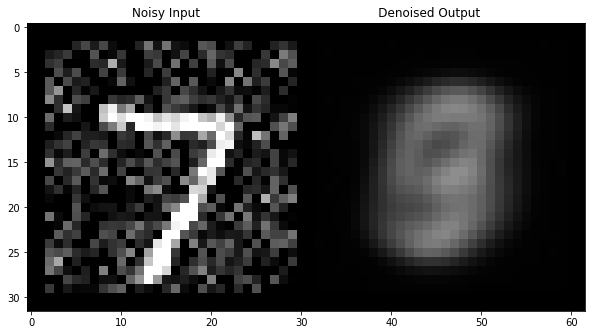

In [6]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

ideal_outputs = images[0].view(-1,28*28).double().to(device)
noise = ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double().to(device)
inputs = ideal_outputs + noise
outImg = net(inputs).data
outImg = outImg.view(-1,28,28)
inImg = inputs.data.view(-1,28,28)
if use_gpu:
    outImg = outImg.cpu()   
    inImg = inImg.cpu()

dispImg = torch.Tensor(2,1,28,28)
dispImg[0] = torch.clamp(inImg,0,1)
dispImg[1] = outImg

# show images
imshow(torchvision.utils.make_grid(dispImg), 'Noisy Input                                              Denoised Output')

## Encoder Weight Visualisation:

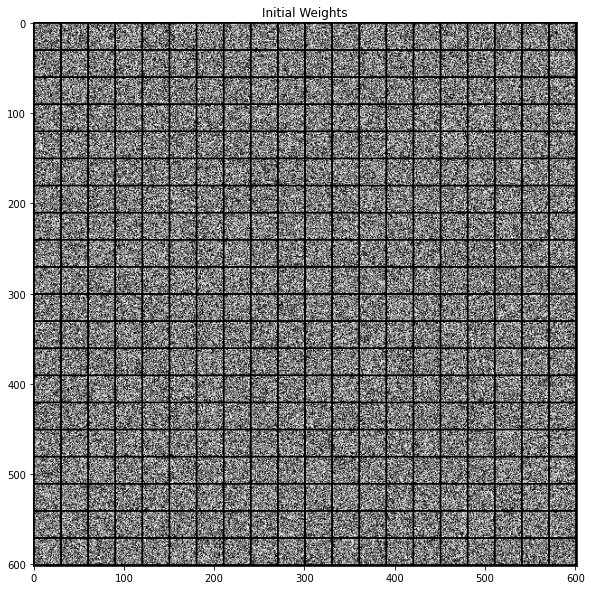

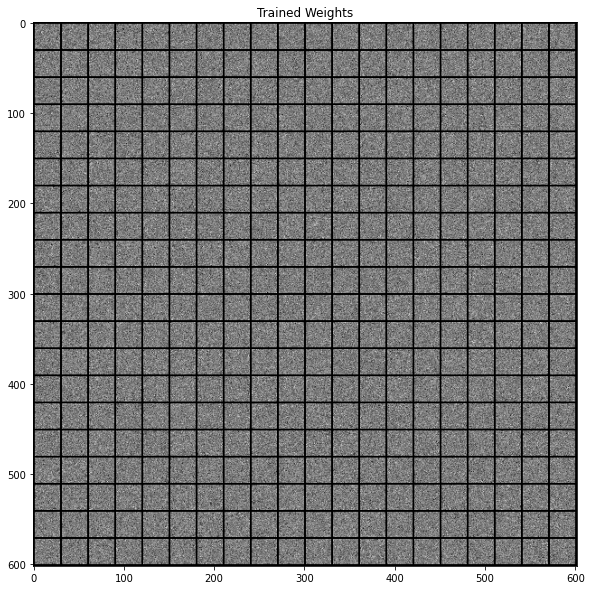

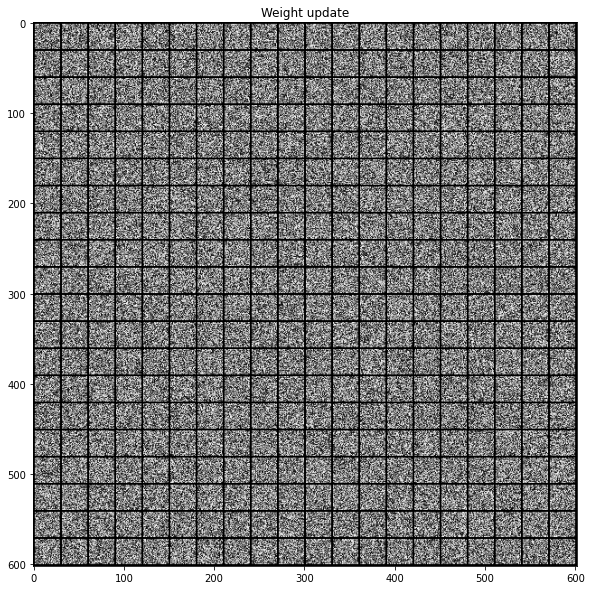

In [7]:
trained_weightsE = copy.deepcopy(net.encoder[0].weight.data)
d_weightsE = init_weightsE - trained_weightsE 

init_weightsE = init_weightsE.view(400,1,28,28)
trained_weightsE = trained_weightsE.view(400,1,28,28)
d_weightsE = d_weightsE.view(400,1,28,28)
if use_gpu:
    init_weightsE = init_weightsE.cpu()
    trained_weightsE = trained_weightsE.cpu()
    d_weightsE = d_weightsE.cpu()    

imshow(torchvision.utils.make_grid(init_weightsE,nrow=20,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weightsE,nrow=20,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weightsE,nrow=20,normalize=True), 'Weight update')

## Decoder Weight Visualisation:

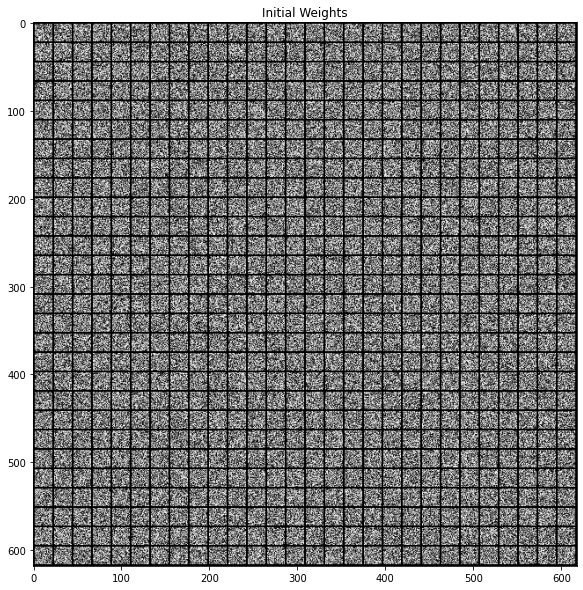

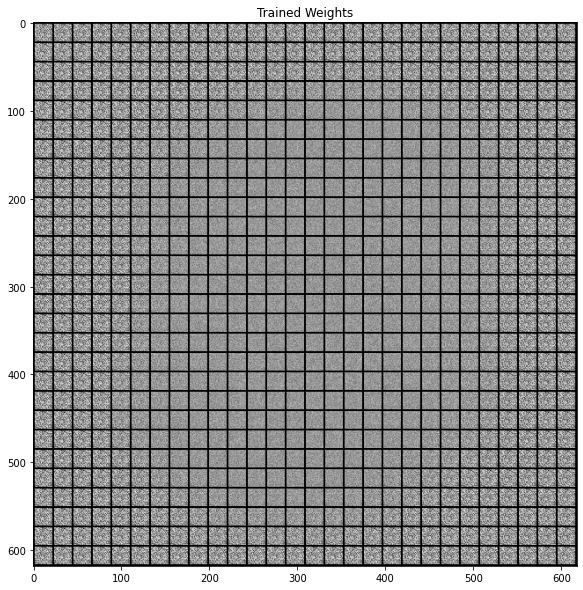

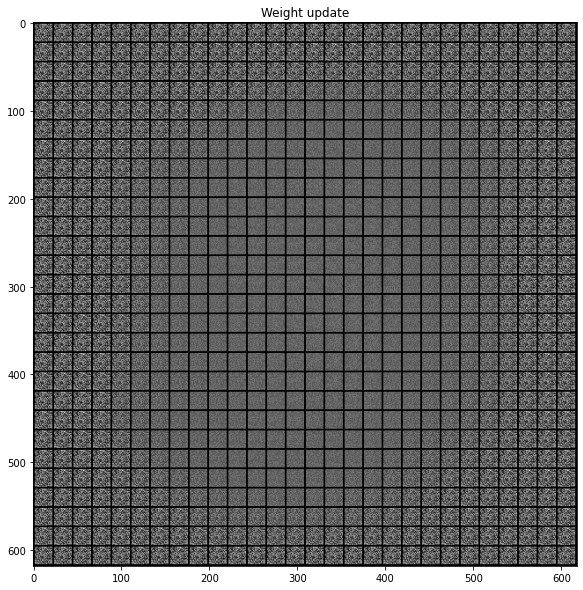

In [8]:
trained_weightsD = copy.deepcopy(net.decoder[0].weight.data)
d_weightsD = init_weightsD - trained_weightsD 

init_weightsD = init_weightsD.view(784,1,20,20)
trained_weightsD = trained_weightsD.view(784,1,20,20)
d_weightsD = d_weightsD.view(784,1,20,20)
if use_gpu:
    init_weightsD = init_weightsD.cpu()
    trained_weightsD = trained_weightsD.cpu()
    d_weightsD = d_weightsD.cpu()    

imshow(torchvision.utils.make_grid(init_weightsD,nrow=28,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weightsD,nrow=28,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weightsD,nrow=28,normalize=True), 'Weight update')

## Modifying the autoencoder for classification: 

In [9]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(400, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.double().to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


## Train Classifier:

In [10]:
iterations = 10
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.view(-1, 28*28).double().to(device), labels.to(device)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        correct = 0
        total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.view(-1, 28*28).double().to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * float(correct) /float(total)))
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


At Iteration : 1 / 10  ;  Train Error : 1.404006 ;Test Accuracy : 84.530000
At Iteration : 2 / 10  ;  Train Error : 0.610547 ;Test Accuracy : 88.120000
At Iteration : 3 / 10  ;  Train Error : 0.462618 ;Test Accuracy : 89.230000
At Iteration : 4 / 10  ;  Train Error : 0.405313 ;Test Accuracy : 89.890000
At Iteration : 5 / 10  ;  Train Error : 0.374655 ;Test Accuracy : 90.330000
At Iteration : 6 / 10  ;  Train Error : 0.355019 ;Test Accuracy : 90.630000
At Iteration : 7 / 10  ;  Train Error : 0.341313 ;Test Accuracy : 90.880000
At Iteration : 8 / 10  ;  Train Error : 0.331090 ;Test Accuracy : 91.160000
At Iteration : 9 / 10  ;  Train Error : 0.322702 ;Test Accuracy : 91.490000
At Iteration : 10 / 10  ;  Train Error : 0.315892 ;Test Accuracy : 91.570000
Finished Training


## Performance of different Classes:

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.view(-1, 28*28).double().to(device))
        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:
            predicted = predicted.cpu()
            
        c = (predicted == labels).squeeze()
        for i in range(BatchSize):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of  zero : 97.959184 %
Accuracy of   one : 97.444934 %
Accuracy of   two : 88.759690 %
Accuracy of three : 90.990099 %
Accuracy of  four : 93.177189 %
Accuracy of  five : 85.762332 %
Accuracy of   six : 93.945720 %
Accuracy of seven : 91.147860 %
Accuracy of eight : 86.858316 %
Accuracy of  nine : 88.503469 %
